# 서비스 모델
- 1. 카메라로 이미지 촬영(있다고 가정)
- 2. ROI(Region of Interest)만 자르기
- 3. objectDetection함수 처리 (input = take이미지파일, output = 64 * 64 생두객체 이미지 리스트)
===========================현재 완료==================================================
- 4. 전처리 멀티프로세싱과 세컨드 프로세싱에서 함수가져오기
    - second_preprocessing.ipynb에서 imgPreprocessing 함수 처리하기(input = 64 * 64 생두이미지, thres값, output = 전처리 된 64 * 64 이미지)

In [2]:
 # 필요한 모듈 불러오기
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch

# 필요한 모듈 가져오기
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
import plotly.offline as py
import plotly.graph_objs as go
%matplotlib inline
import glob

In [7]:
# 데이터 로드
src_path = '/Users/gabriel8452/Desktop/coffeebean_project/Coffee_Inspection_preprocessing/data/normal_data/real_data_normal/20200518_take1.jpg'
img = Image.open(src_path)


def multi_objectDetection(img):
    img_color = np.array(img)
    img = np.array(img.convert('L'))

    img_color_ROI = img_color[733:1437,710:1414]
    img_ROI = img[733:1437,710:1414]
    

    # 데이터 이진화
    _, src_bin = cv2.threshold(img_ROI, 180, 255, cv2.THRESH_BINARY)
    src_bin = cv2.bitwise_not(src_bin)

    # 데이터 처리
    img_list = list()
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)
    dst = cv2.cvtColor(img_ROI, cv2.COLOR_GRAY2BGR)
    alpha = 3
    SIZE = 64
    for i in range(1,nlabels):
        stat = stats[i]
        x = stat[0] - alpha
        y = stat[1] - alpha
        width = stat[2] + 2*alpha
        height = stat[3] + 2*alpha
        n_pixel = stat[4]

        
        # 최대 픽셀 지정해서 임계값보다 크면 패스해버리기
        if n_pixel < 500 or width > 64 or height > 64 : continue
        
        cv2.rectangle(dst, (x, y), (x+width, y+height), (0,100,255))
        
        
        delta_x = int((SIZE - width) / 2)
        delta_y = int((SIZE - height) / 2)
        
        tmp1 = img_color_ROI[y : y+height, x : x+width, :].copy()
        tmp2 = np.zeros((64,64,3), dtype = int)
        
        # print(stat) # 가장자리쪽에 있는 생두들은 ROI를 벗어나는것들이 있다.
        try:
            for i in range(3):
                tmp2[delta_y : delta_y + height, delta_x : delta_x + width , i] = tmp1[0:height, 0:width, i]
                
        except:
            print('Error! Go to home!')
        
        img_list.append(tmp2)
    return img_list

Error! Go to home!
Error! Go to home!
Error! Go to home!
Error! Go to home!


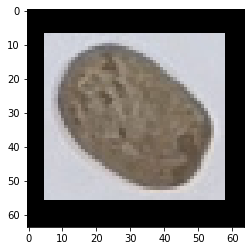

In [12]:
plt.imshow(multi_objectDetection(img)[6])

In [14]:
multi_objectDetection(img)[6].shape

Error! Go to home!
Error! Go to home!
Error! Go to home!
Error! Go to home!


(64, 64, 3)

In [17]:
def imgPreprocessing(img, thres):
    ############################################################################
    # <이미지 노이즈 및 배경 제거>

    # 그레이 스케일로 변환
    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    
    # 데이터형 변환
    # img_tensor = torch.LongTensor(np.array(img))

    # 바이너리로 변환
    ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # 바이너리 이미지와 원본 이미지의 데이터가 일치하는 부분 만 다시 추출히기
    # tmp = np.zeros_like(src)
    # for i in range(3):
    #     tmp[:,:,i] = (src[:,:,i] * binary)

    tmp = np.zeros_like(img)
    for y in range(64):
        for x in range(64):
            if (binary != 0)[y,x]:
                for i in range(3):
                    tmp[y,x,i] = src[y,x,i]
    
    src_processed = tmp

    # ax1 = fig.add_subplot(1,3,1)
    # ax1.imshow(src_processed)
    

    height = src_processed.shape[0]
    width = src_processed.shape[1]

    ############################################################################
    # <생두 무게 중심 구하기>
    R = list()
    for y in range(height):
        for x in range(width):
            if binary[y,x]:            
                R.append([x, y])

    # 질량의 합
    M = len(R)

    # 질량중심 벡터는 이미지를 기준으로 (x,y)
    R = np.array(R)
    R_x = R[:,0]
    R_y = R[:,1]

    R_x_sum = R_x.sum()
    R_y_sum = R_y.sum()

    center = np.round(R_x_sum/M).real , (np.round(R_y_sum/M)).real

    height_center = center[1]
    width_center = center[0]

    # print('center:', height_center, width_center)

 
    ############################################################################
    # <객체 외부의 노이즈 데이터 처리하기>

    # 바이너리의 윤곽선 추출
    _, contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)    

    # 생두 객체 윤곽과 윤곽벡터 구하기
    contours_leng = [len(i) for i in contours if len(i) != 252]
    # print('contours_leng: ', contours_leng)
    max = np.array(contours_leng).max()
    # print('max: ', max)
    contour_vector = list()
    for i in contours:
        if len(i) == max:
            # print(i)
            for point in i:
                contour_vector.append((point[0][1]-height_center, point[0][0]-width_center))
            
            # 윤곽 벡터 사이즈와 최대 사이즈 구하기
            vector_size = np.sqrt(np.array(contour_vector)[:,0]**2 + np.array(contour_vector)[:,1]**2 )
            max_size = vector_size.max()
    # print('max_size: ', max_size)

    # 질량 벡터와 윤곽벡터를 비교하는 코드 짜기
    R_size = np.sqrt((R[:,0] - width_center) ** 2 + (R[:,1] - height_center) ** 2)
    R_total = np.hstack([R,R_size.reshape((R_size.shape[0],1))])

    # print('R_size_max: ', R_size.max())
    # max_size 보다 큰 R 좌표들만 추출하기
    R_filtered = R_total[R_total[:,2] > max_size]


    # R_filtered의 좌표를 이용해서 노이즈 처리
    for i in R_filtered[:,:2]:
        # print(i[0].real, -i[1].imag)
        src_processed[int(i[1]),int(i[0])] = 0

    # ax2 = fig.add_subplot(1,3,2)
    # ax2.imshow(binary)
    # ax3 = fig.add_subplot(1,3,3)
    # ax3.imshow(src_processed)


    ############################################################################
    # <이미지의 중심과 생두의 무게중심 일치시키기>
    
    # 1. 이미지 센터 좌표를 구한다 
    src_center = np.array([src_processed.shape[1] / 2, src_processed.shape[0] / 2]) # (x, y)

    # 2. 객체의 중심을 구한다
    object_center = np.array([height_center, width_center]) # (x, y)

    # 3. 이미지 중심과 객체의 중심의 차이를 구한다
    delta = object_center - src_center # (x, y)

    # 4. 이미지 이동
    height, width = src_processed.shape[:2]
    M = np.float32([[1, 0, -delta[1]], [0, 1, -delta[0]]]) # 이미지를 width 방향으로 delta[0]만큼 , hiehgt 방향으로 -delta[1]만큼
    img_translation = cv2.warpAffine(src_processed, M, (width,height))

    return img, binary, src_processed, img_translation

In [19]:
imgPreprocessing(img)[6].shape

TypeError: imgPreprocessing() missing 1 required positional argument: 'thres'